In [2]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
from pathlib import Path
import re
from collections import Counter
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.utils.data as data
from torchvision import datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [3]:
train_feature_75ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_64wz_75ol.npy')
train_label_75ol = np.load('../Data/UTDMHAD_data/UTD_train_label_64wz_75ol.npy')
test_feature_75ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_64wz_75ol.npy')
test_label_75ol = np.load('../Data/UTDMHAD_data/UTD_test_label_64wz_75ol.npy')

train_feature_50ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_64wz_50ol.npy')
train_label_50ol = np.load('../Data/UTDMHAD_data/UTD_train_label_64wz_50ol.npy')
test_feature_50ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_64wz_50ol.npy')
test_label_50ol = np.load('../Data/UTDMHAD_data/UTD_test_label_64wz_50ol.npy')

train_feature_25ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_64wz_25ol.npy')
train_label_25ol = np.load('../Data/UTDMHAD_data/UTD_train_label_64wz_25ol.npy')
test_feature_25ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_64wz_25ol.npy')
test_label_25ol = np.load('../Data/UTDMHAD_data/UTD_test_label_64wz_25ol.npy')

train_feature_0ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_64wz_0ol.npy')
train_label_0ol = np.load('../Data/UTDMHAD_data/UTD_train_label_64wz_0ol.npy')
test_feature_0ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_64wz_0ol.npy')
test_label_0ol = np.load('../Data/UTDMHAD_data/UTD_test_label_64wz_0ol.npy')

# 64 window_size %75 overlapping

In [4]:
train_dataset_75ol = TensorDataset(torch.from_numpy(train_feature_75ol).to(torch.float32),torch.from_numpy(train_label_75ol).to(torch.float32))

test_dataset_75ol = TensorDataset(torch.from_numpy(test_feature_75ol).to(torch.float32),torch.from_numpy(test_label_75ol).to(torch.float32))


In [5]:
train_loader_75ol = data.DataLoader(dataset = train_dataset_75ol, batch_size = 32, shuffle = True)

test_loader_75ol = data.DataLoader(dataset = test_dataset_75ol, batch_size = 32, shuffle = False)

In [35]:
class CNN_UTD(nn.Module):
    def __init__(self):
        super(CNN_UTD, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(4224, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_75 = CNN_UTD().to(device)

In [36]:
epoches = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_75.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [37]:
## training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_75ol:
        imgs = imgs.reshape(len(imgs),1,32,12)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_75(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  26.652953276520716  % Loss:  2.410090876297212
Epoch:  2 accuracy:  43.241257713781955  % Loss:  1.7304281953354956
Epoch:  3 accuracy:  50.47017337643256  % Loss:  1.474623506897492
Epoch:  4 accuracy:  57.31707317073171  % Loss:  1.28027124723918
Epoch:  5 accuracy:  62.19512195121951  % Loss:  1.1269277737174235
Epoch:  6 accuracy:  65.22186306200412  % Loss:  1.0352648734486718
Epoch:  7 accuracy:  69.52688803996473  % Loss:  0.8928823413703363
Epoch:  8 accuracy:  72.62709374081693  % Loss:  0.8023004149886924
Epoch:  9 accuracy:  75.47751983543932  % Loss:  0.7245515137211258
Epoch:  10 accuracy:  78.18101674992654  % Loss:  0.6265140071581227
Epoch:  11 accuracy:  80.23802527181898  % Loss:  0.5700831822526287
Epoch:  12 accuracy:  82.2656479576844  % Loss:  0.5291379993790192
Epoch:  13 accuracy:  83.47046723479284  % Loss:  0.482639439019239
Epoch:  14 accuracy:  84.49897149573906  % Loss:  0.45304479019742616
Epoch:  15 accuracy:  85.58624742873934  % Los

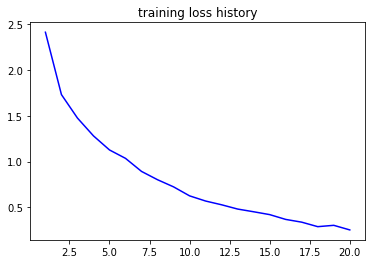

In [39]:
import matplotlib.pyplot as plt
x = []
for i in range(1,21):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [40]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_75ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,12)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_75(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  61.13776559287183


# 64 window_size %50 overlapping

In [17]:
train_dataset_50ol = TensorDataset(torch.from_numpy(train_feature_50ol).to(torch.float32),torch.from_numpy(train_label_50ol).to(torch.float32))

test_dataset_50ol = TensorDataset(torch.from_numpy(test_feature_50ol).to(torch.float32),torch.from_numpy(test_label_50ol).to(torch.float32))

train_loader_50ol = data.DataLoader(dataset = train_dataset_50ol, batch_size = 32, shuffle = True)

test_loader_50ol = data.DataLoader(dataset = test_dataset_50ol, batch_size = 32, shuffle = False)


In [41]:
class CNN_UTD_50(nn.Module):
    def __init__(self):
        super(CNN_UTD_50, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(4224, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_50 = CNN_UTD_50().to(device)
epoches = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_50.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [42]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_50ol:
        imgs = imgs.reshape(len(imgs),1,32,12)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_50(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  18.660005877167205  % Loss:  2.789534646774007
Epoch:  2 accuracy:  34.29327064354981  % Loss:  2.0811869619048644
Epoch:  3 accuracy:  42.25683220687628  % Loss:  1.7918559635911033
Epoch:  4 accuracy:  47.928298560094035  % Loss:  1.5732410778509123
Epoch:  5 accuracy:  53.776079929473994  % Loss:  1.4156971891349721
Epoch:  6 accuracy:  57.684396121069646  % Loss:  1.271762276364264
Epoch:  7 accuracy:  62.444901557449306  % Loss:  1.1353088461350058
Epoch:  8 accuracy:  65.85365853658537  % Loss:  1.0324666500091553
Epoch:  9 accuracy:  70.46723479282986  % Loss:  0.8951127055649445
Epoch:  10 accuracy:  73.55274757566853  % Loss:  0.8042206533044298
Epoch:  11 accuracy:  76.13870114604761  % Loss:  0.7272459469108938
Epoch:  12 accuracy:  77.96062297972378  % Loss:  0.6578477115553116
Epoch:  13 accuracy:  79.16544225683221  % Loss:  0.6118153989593559
Epoch:  14 accuracy:  83.51454598883338  % Loss:  0.4995865189583502
Epoch:  15 accuracy:  85.89479870702321 

In [43]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_50ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,12)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_50(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  53.32419465387252


# 64 window_size %25 overlapping

In [24]:
train_dataset_25ol = TensorDataset(torch.from_numpy(train_feature_25ol).to(torch.float32),torch.from_numpy(train_label_25ol).to(torch.float32))

test_dataset_25ol = TensorDataset(torch.from_numpy(test_feature_25ol).to(torch.float32),torch.from_numpy(test_label_25ol).to(torch.float32))

train_loader_25ol = data.DataLoader(dataset = train_dataset_25ol, batch_size = 32, shuffle = True)

test_loader_25ol = data.DataLoader(dataset = test_dataset_25ol, batch_size = 32, shuffle = False)


In [49]:
class CNN_UTD_25(nn.Module):
    def __init__(self):
        super(CNN_UTD_25, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(4224, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_25 = CNN_UTD_25().to(device)
epoches = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_25.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [50]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_25ol:
        imgs = imgs.reshape(len(imgs),1,32,12)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_25(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  14.367562802996915  % Loss:  2.928686867297535
Epoch:  2 accuracy:  31.42353459673865  % Loss:  2.283009779285377
Epoch:  3 accuracy:  40.01762891141472  % Loss:  1.9031359058030894
Epoch:  4 accuracy:  45.52666372851476  % Loss:  1.6914754837331638
Epoch:  5 accuracy:  52.093433230498015  % Loss:  1.4960484513094727
Epoch:  6 accuracy:  57.60246804759806  % Loss:  1.3378986044668815
Epoch:  7 accuracy:  60.46716615249009  % Loss:  1.201899655268226
Epoch:  8 accuracy:  63.155575143234906  % Loss:  1.0816934906261069
Epoch:  9 accuracy:  69.89863375936535  % Loss:  0.9328893028514486
Epoch:  10 accuracy:  71.13265755839576  % Loss:  0.8636608367234888
Epoch:  11 accuracy:  74.52622300572939  % Loss:  0.7861558341644179
Epoch:  12 accuracy:  78.49272807404142  % Loss:  0.6749595617744285
Epoch:  13 accuracy:  82.01851035698546  % Loss:  0.5439796968245171
Epoch:  14 accuracy:  84.31026884089907  % Loss:  0.4725023493380614
Epoch:  15 accuracy:  87.1749669457911  % L

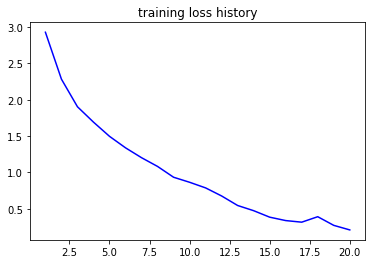

In [51]:
import matplotlib.pyplot as plt
x = []
for i in range(1,21):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [52]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_25ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,12)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_25(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  49.84583761562179


# 64 window_size %0 overlapping

In [30]:
train_dataset_0ol = TensorDataset(torch.from_numpy(train_feature_0ol).to(torch.float32),torch.from_numpy(train_label_0ol).to(torch.float32))

test_dataset_0ol = TensorDataset(torch.from_numpy(test_feature_0ol).to(torch.float32),torch.from_numpy(test_label_0ol).to(torch.float32))

train_loader_0ol = data.DataLoader(dataset = train_dataset_0ol, batch_size = 32, shuffle = True)

test_loader_0ol = data.DataLoader(dataset = test_dataset_0ol, batch_size = 32, shuffle = False)


In [44]:
class CNN_UTD_0(nn.Module):
    def __init__(self):
        super(CNN_UTD_0, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(4224, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_0 = CNN_UTD_0().to(device)
epoches = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_0.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [45]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_0ol:
        imgs = imgs.reshape(len(imgs),1,32,12)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_0(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  12.404467960023515  % Loss:  3.0233480400509305
Epoch:  2 accuracy:  28.395061728395063  % Loss:  2.410914597687898
Epoch:  3 accuracy:  34.97942386831276  % Loss:  2.057758064181716
Epoch:  4 accuracy:  40.975896531452086  % Loss:  1.8186475899484422
Epoch:  5 accuracy:  50.3233392122281  % Loss:  1.6192681082972773
Epoch:  6 accuracy:  52.55731922398589  % Loss:  1.4562444123956892
Epoch:  7 accuracy:  59.31804820693709  % Loss:  1.2823536252533947
Epoch:  8 accuracy:  62.316284538506764  % Loss:  1.186236196094089
Epoch:  9 accuracy:  66.01998824221046  % Loss:  1.0663131133273795
Epoch:  10 accuracy:  71.5461493239271  % Loss:  0.8828773272258265
Epoch:  11 accuracy:  75.19106407995297  % Loss:  0.7792473026999721
Epoch:  12 accuracy:  77.13109935332157  % Loss:  0.7287383774916331
Epoch:  13 accuracy:  82.59847148736037  % Loss:  0.5418479685430173
Epoch:  14 accuracy:  85.00881834215167  % Loss:  0.4911627843976021
Epoch:  15 accuracy:  86.06701940035273  % L

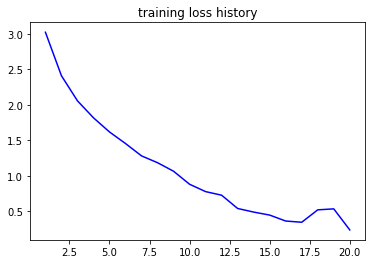

In [48]:
import matplotlib.pyplot as plt
x = []
for i in range(1,21):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [47]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_0ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,12)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_0(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  48.49315068493151
